# Training the second model using the labeled data

In [1]:
!pip install transformers evaluate albumentations timm accelerate datasets torchmetrics torch

# Get annotated data for model training
!rm -rf AnnotatedData
!rm -rf AnnotatedData.zip
!wget -q https://github.com/portoaj/CSE151A-Project/raw/main/AnnotatedData.zip
!unzip -n -qq AnnotatedData.zip -d AnnotatedData
!rm -rf detr-resnet-101

In [2]:
# Lets load the annotations file
import json

with open('/content/AnnotatedData/_annotations.coco.json') as annotations_file:
  annotations_object = json.load(annotations_file)

# The different categories of information stored in the annotations file
print(annotations_object.keys())

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


In [3]:
annotations = annotations_object['annotations']
images = annotations_object['images']

num_annotations = len(annotations)
num_images = len(images)
print(f'There are {num_annotations} annotations and {num_images} images')

There are 1713 annotations and 36 images


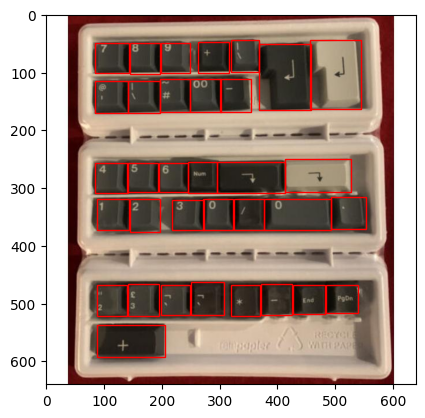

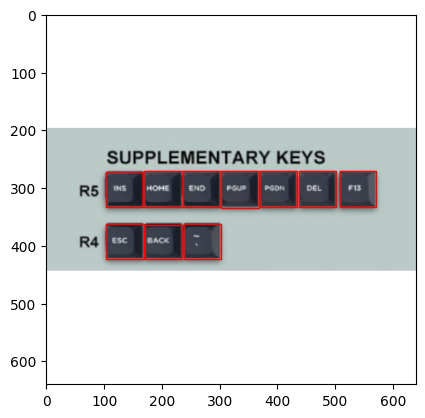

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import os

def show_annotated_image(image_id, edgecolor='r'):
  im = Image.open(f'AnnotatedData/{images[image_id]["file_name"]}' )
  # Create figure and axes
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(im)

  for annotation in annotations:
    if annotation['image_id'] == image_id:
      # Create a Rectangle patch
      width, height = im.size
      data = annotation['bbox']
      x = float(data[0])
      y = float(data[1])
      width = float(data[2])
      height = float(data[3])
      #print(x,y,width,height)
      rect = patches.Rectangle((x,y),width,height, linewidth=1, edgecolor=edgecolor, facecolor='none')
      ax.add_patch(rect)

  # Add the patch to the Axes
  plt.show()

# Here we display the first 2 images with their annotations
for i in range(2):
  show_annotated_image(i)

In [5]:
# Training code adapted from https://huggingface.co/docs/transformers/en/tasks/object_detection
from transformers import AutoImageProcessor, AutoModelForObjectDetection, TrainingArguments, Trainer

id2label = {0:'background', 1: 'keycap'}
label2id = {'keycap': 1, 'background': 0}

checkpoint = "facebook/deformable-detr-box-supervised"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,)
model = AutoModelForObjectDetection.from_pretrained(checkpoint)

!rm -rf detr-resnet-50
MODEL_NAME = 'deformable-detr'
NUM_TRAIN_EPOCHS = 100
MODEL_SAVE_PATH = f'/content/{MODEL_NAME}/checkpoint-{NUM_TRAIN_EPOCHS * 7}'


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
import numpy as np
import torch
print(annotations)
print(images)

[{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [85, 49, 58, 52], 'area': 3016, 'segmentation': [], 'iscrowd': 0}, {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [144, 49, 53, 53], 'area': 2809, 'segmentation': [], 'iscrowd': 0}, {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [198, 48, 51, 53], 'area': 2703, 'segmentation': [], 'iscrowd': 0}, {'id': 3, 'image_id': 0, 'category_id': 1, 'bbox': [262, 47, 55, 53], 'area': 2915, 'segmentation': [], 'iscrowd': 0}, {'id': 4, 'image_id': 0, 'category_id': 1, 'bbox': [320, 44, 49, 54], 'area': 2646, 'segmentation': [], 'iscrowd': 0}, {'id': 5, 'image_id': 0, 'category_id': 1, 'bbox': [85, 115, 57, 54], 'area': 3078, 'segmentation': [], 'iscrowd': 0}, {'id': 6, 'image_id': 0, 'category_id': 1, 'bbox': [142, 114, 55, 55], 'area': 3025, 'segmentation': [], 'iscrowd': 0}, {'id': 7, 'image_id': 0, 'category_id': 1, 'bbox': [196, 111, 52, 57], 'area': 2964, 'segmentation': [], 'iscrowd': 0}, {'id': 8, 'image_id': 0, 'category_id': 1, 'bb

In [7]:
def generate_dataset(image_ids):
  dataset = []
  for image_id in image_ids:
    image_obj = list(filter(lambda image: (image['id'] == image_id), images))[0]
    #print(image_obj)
    relevant_annotations = list(filter(lambda annotation: (annotation['image_id'] == image_id), annotations))

    objects = {'id': [annotation['id'] for annotation in relevant_annotations], 'area': [annotation['area'] for annotation in relevant_annotations], 'bbox':[annotation['bbox'] for annotation in relevant_annotations], 'category':[annotation['category_id'] for annotation in relevant_annotations]}

    dataset.append({'image_id': image_id, 'image': Image.open('AnnotatedData/' + image_obj['file_name']), 'width': image_obj['width'], 'height': image_obj['height'], 'objects': objects})
  return dataset

raw_train_dataset = generate_dataset(range(int(len(images) *.7)))
raw_validation_dataset = generate_dataset(range(int(len(images) *.7), int(len(images) *.8)))
raw_test_dataset = generate_dataset(range(int(len(images) *.8), len(images)))

print(len(raw_train_dataset), len(raw_validation_dataset), len(raw_test_dataset))

assert len(raw_train_dataset) + len(raw_validation_dataset) + len(raw_test_dataset) == len(images)

25 3 8


In [8]:
print(raw_train_dataset)

[{'image_id': 0, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x793C8E907340>, 'width': 640, 'height': 640, 'objects': {'id': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], 'area': [3016, 2809, 2703, 2915, 2646, 3078, 3025, 2964, 3135, 3021, 10266, 10235, 6328, 6435, 2703, 2601, 2754, 2912, 2968, 2968, 2805, 2808, 3360, 6380, 2860, 2756, 2968, 2499, 3136, 2805, 2862, 2744, 2688, 6608], 'bbox': [[85, 49, 58, 52], [144, 49, 53, 53], [198, 48, 51, 53], [262, 47, 55, 53], [320, 44, 49, 54], [85, 115, 57, 54], [142, 114, 55, 55], [196, 111, 52, 57], [248, 111, 55, 57], [301, 111, 53, 57], [457, 44, 87, 118], [369, 50, 89, 115], [414, 250, 113, 56], [296, 254, 117, 55], [245, 255, 51, 53], [195, 256, 51, 51], [140, 256, 54, 51], [85, 257, 56, 52], [87, 319, 56, 53], [144, 319, 53, 56], [218, 321, 55, 51], [272, 318, 52, 54], [493, 315, 60, 56], [376, 318, 116, 55], [325, 318, 52, 55

In [9]:
import albumentations, datasets
from datasets import Dataset
#from datasets import from_list


def train_formatted_anns(image_id, category, area, bbox):
  annotations = []
  for i in range(0, len(category)):
      new_ann = {
          "image_id": image_id,
          "category_id": category[i],
          "isCrowd": 0,
          "area": area[i],
          "bbox": list(bbox[i]),
      }
      annotations.append(new_ann)

  return annotations

# format annotations the same as for training, no need for data augmentation
def validation_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations

transform = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=0.3),
        albumentations.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.15, p=.5),
        albumentations.Downscale(scale_min=.15, scale_max=.15)

    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

def train_transform_ann(examples):
  image_ids = examples["image_id"]
  images, bboxes, area, categories = [], [], [], []
  for image, objects in zip(examples["image"], examples["objects"]):
      image = np.array(image.convert("RGB"))[:, :, ::-1]
      out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

      area.append(objects["area"])
      images.append(out["image"])
      bboxes.append(out["bboxes"])
      categories.append(out["category"])

  targets = [
      {"image_id": id_, "annotations": train_formatted_anns(id_, cat_, ar_, box_)}
      for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
  ]

  return image_processor(images=images, annotations=targets, return_tensors="pt")

def validation_transform_ann(examples):
  image_ids = examples["image_id"]
  images, bboxes, area, categories = [], [], [], []
  for image, objects in zip(examples["image"], examples["objects"]):
      image = np.array(image.convert("RGB"))[:, :, ::-1]
      out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
      area.append(objects["area"])
      #print(image)
      images.append(image)
      #print(objects)
      bboxes.append(objects["bbox"])
      categories.append(objects["category"])

  targets = [
      {"image_id": id_, "annotations": train_formatted_anns(id_, cat_, ar_, box_)}
      for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
  ]

  return image_processor(images=images, annotations=targets, return_tensors="pt")


train_dataset = Dataset.from_list(raw_train_dataset).with_transform(train_transform_ann)
validation_dataset = Dataset.from_list(raw_validation_dataset).with_transform(validation_transform_ann)
#test_dataset = Dataset.from_list(raw_test_dataset).with_transform(validation_transform_ann)

def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1692: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


In [10]:
training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    per_device_train_batch_size=4,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    fp16=True,
    save_steps=20,
    logging_steps=10,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    evaluation_strategy='steps'
)


# Train model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=image_processor,
)

trainer.train()

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Step,Training Loss,Validation Loss
10,3.951100,4.745657
20,3.567000,4.008276
30,2.744300,3.200257
40,2.653400,2.431363
50,2.185400,1.951010
60,1.812100,1.687905
70,1.882900,1.503533
80,1.724500,1.366652
90,1.683000,1.303790
100,1.652700,1.274504


Removed shared tensor {'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.0.layers.0.bias', 'class_embed.0.weight', 'class_embed.0.bias', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.0.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading
Checkpoint destination directory deformable-detr/checkpoint-40 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory deformable-detr/checkpoint-60 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=700, training_loss=1.124395593234471, metrics={'train_runtime': 1151.8835, 'train_samples_per_second': 2.17, 'train_steps_per_second': 0.608, 'total_flos': 1.2436420896e+18, 'train_loss': 1.124395593234471, 'epoch': 100.0})

<Axes: >

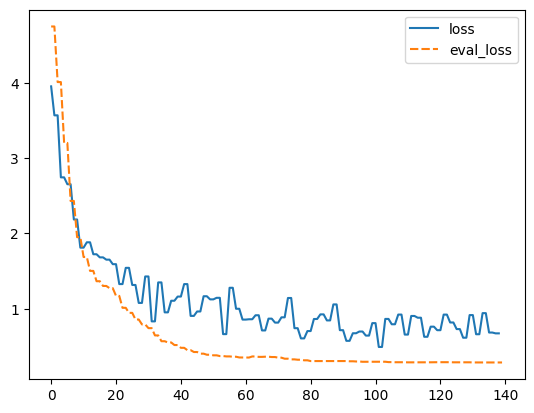

In [11]:
import pandas as pd
import seaborn as sns

training_history = pd.DataFrame(trainer.state.log_history)
training_history = training_history.fillna(method='bfill')
trainer.model
sns.lineplot(data=training_history[['loss', 'eval_loss']])

## Evaluating the Train/ Loss Graph

Very oddly the eval_loss was actually lower than the training loss. I think this is somewhat due to chance as the validation is pretty small at only 3/4 images so I don't think that necessarily means anthing. That being said, it does look like both the training loss and validation were situated in the middle of the model complexity curve.I don't believe the model is overfitting because if the model was overfitting I would expect the validation loss to begin increasing towards the end of the training but it seems to stay relatively level.

In [12]:
import json


# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_annotation_file_images(val_dataset):
    output_json = {}
    path_output = f"{os.getcwd()}/val/"

    if not os.path.exists(path_output):
        os.makedirs(path_output)

    path_anno = os.path.join(path_output, "ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []

    for example in val_dataset:
        print(example)
        ann = validation_formatted_anns(example["image_id"], example["objects"])

        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip([data['image'] for data in val_dataset], [data["image_id"] for data in val_dataset]):
        path_img = os.path.join(path_output, f"{img_id}.png")
        im.save(path_img)

    return path_output, path_anno

In [13]:
import torchvision


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, ann_file):
        super().__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained(MODEL_SAVE_PATH)
path_output, path_anno = save_annotation_file_images(raw_test_dataset)
test_ds_coco_format = CocoDetection(path_output, im_processor, path_anno)

#print(test_ds_coco_format)

{'image_id': 28, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x793C98F94280>, 'width': 640, 'height': 640, 'objects': {'id': [1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232], 'area': [3024, 3240, 3294, 3416, 3360, 3186, 3180, 3240, 3186, 2915, 2915, 2915, 5772, 2916, 2862, 2916, 3024, 2970, 3025, 6102, 6272, 3024], 'bbox': [[160, 464, 54, 56], [239, 141, 54, 60], [296, 142, 54, 61], [352, 142, 56, 61], [409, 142, 56, 60], [239, 200, 54, 59], [298, 199, 53, 60], [353, 199, 54, 60], [410, 199, 54, 59], [241, 260, 53, 55], [297, 260, 53, 55], [354, 260, 53, 55], [411, 260, 52, 111], [239, 318, 54, 54], [297, 318, 53, 54], [354, 317, 54, 54], [240, 374, 54, 56], [297, 375, 54, 55], [354, 375, 55, 55], [412, 374, 54, 113], [239, 432, 112, 56], [355, 432, 54, 56]], 'category': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}
{'image_id': 29, 'image': <PIL.Jpe

In [36]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained(MODEL_SAVE_PATH)
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        #print(batch)
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized
        #print('labels:', labels[0]['class_labels'].shape, '\n')
        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
        #print('shape', outputs['pred_boxes'].shape, '\n')

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to Pascal VOC format (xmin, ymin, xmax, ymax)
        #print(labels)
        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

100%|██████████| 8/8 [02:04<00:00, 15.59s/it]


Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.622
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.793
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.760
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.543
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.662
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.572
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.860
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [35]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_SAVE_PATH)
model = AutoModelForObjectDetection.from_pretrained(MODEL_SAVE_PATH)

images = []
for image_num in range(28,36):
  images.append(Image.open(f'/content/val/{image_num}.png'))
  #image = Image.open('/content/val/28.png')

def id2label(id):
  if id == 1:
    return 'keycap'
  else:
    return 'invalid prediction'

image_results = []
for image in tqdm(images):
  with torch.no_grad():
      inputs = image_processor(images=image, return_tensors="pt")
      outputs = model(**inputs)
      #print(outputs.keys())
      target_sizes = torch.tensor([image.size[::-1]])
      results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes )[0]
      image_results.append(results)

  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
      box = [round(i, 2) for i in box.tolist()]
      #print(label.item())
      #print(
      #    f"Detected {id2label(label.item())} with confidence "
      #    f"{round(score.item(), 3)} at location {box}"
      #)


100%|██████████| 8/8 [01:58<00:00, 14.81s/it]


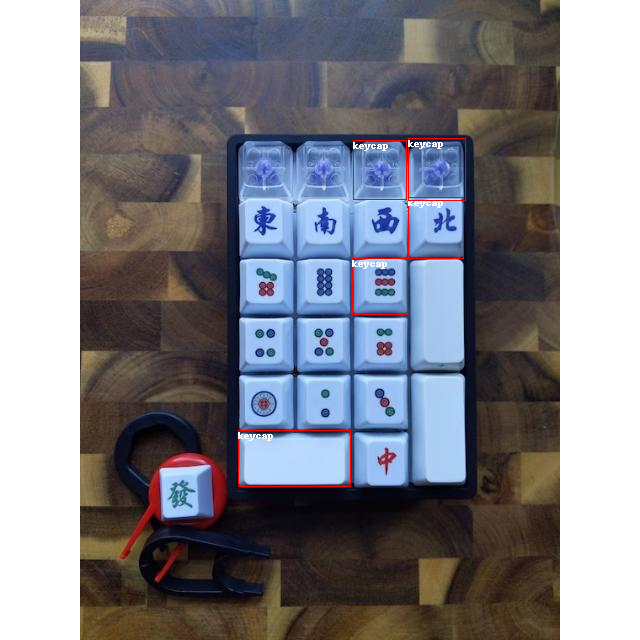

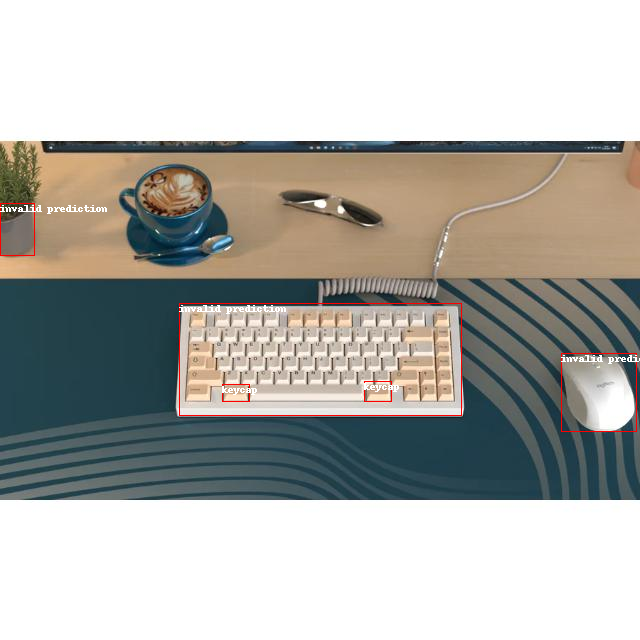

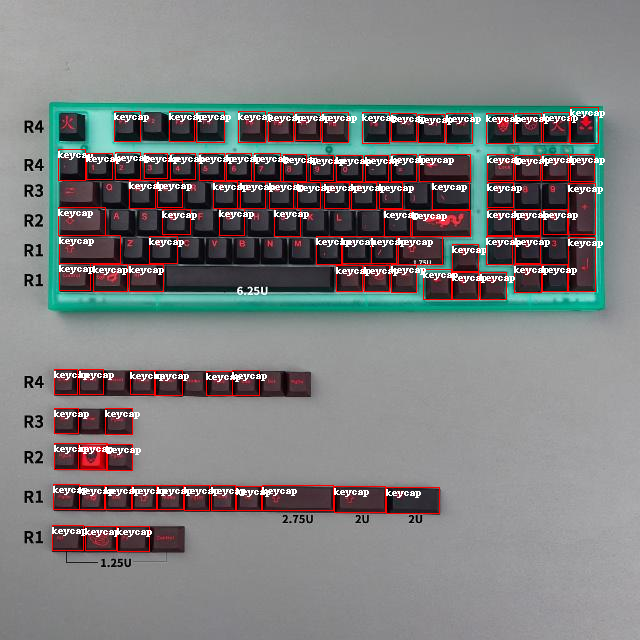

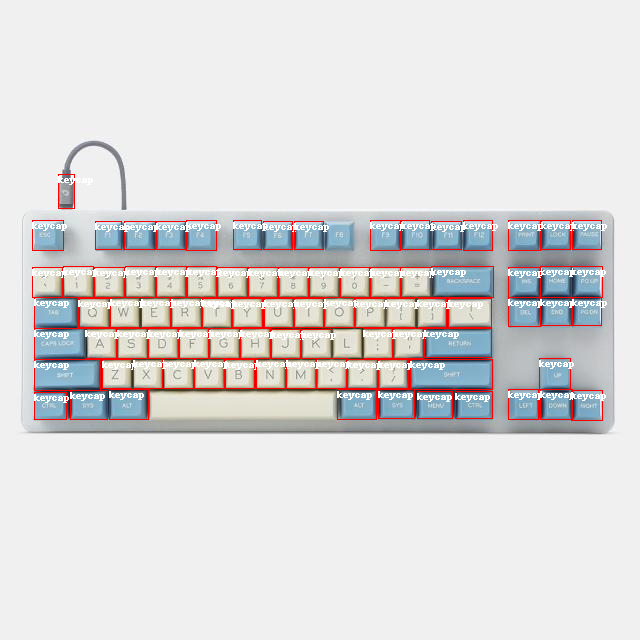

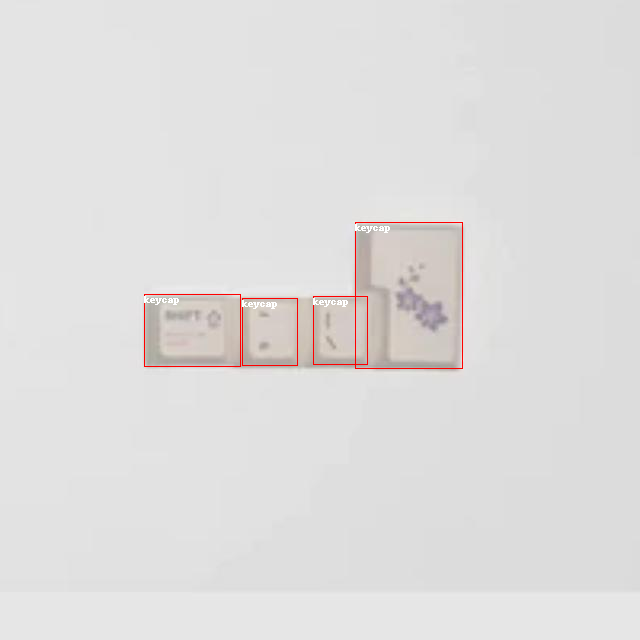

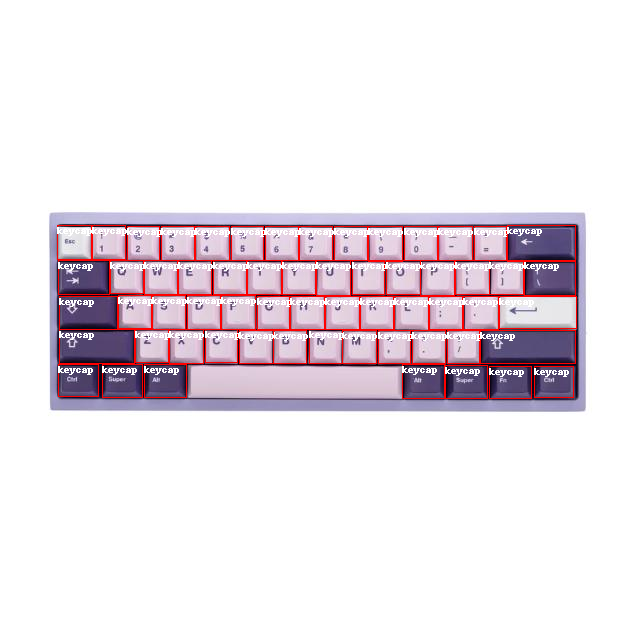

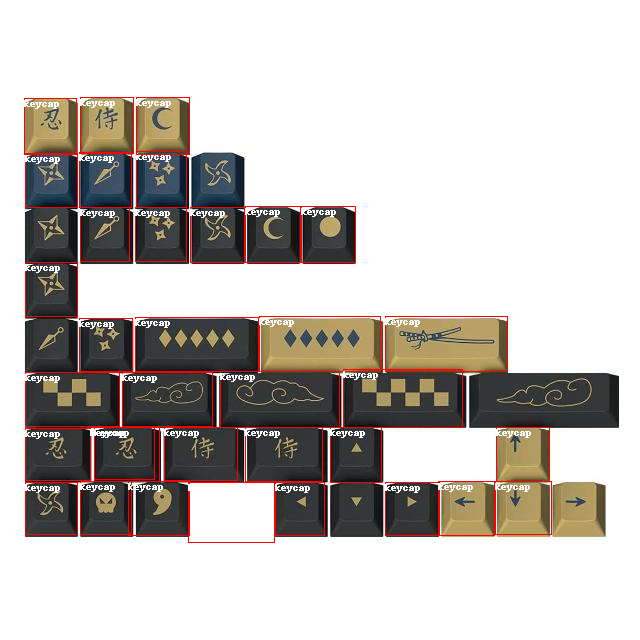

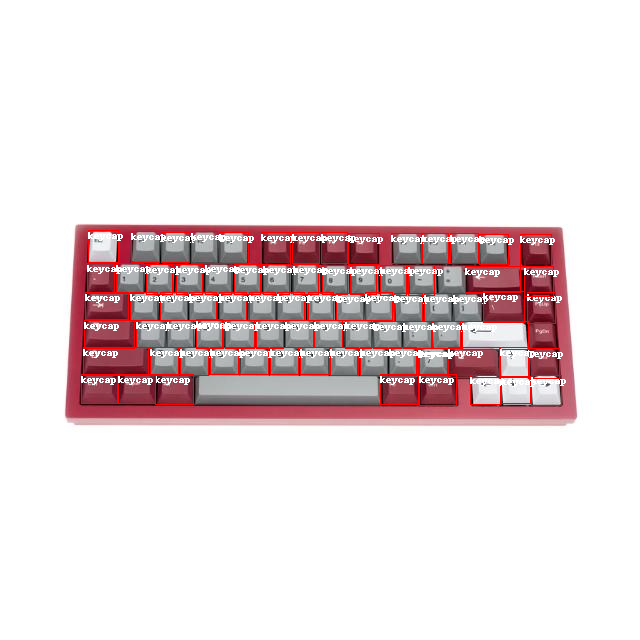

In [33]:
from PIL import ImageDraw
for idx, image in enumerate(images):
  draw = ImageDraw.Draw(image)
  results = image_results[idx]
  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
      box = [round(i, 2) for i in box.tolist()]
      x, y, x2, y2 = tuple(box)
      draw.rectangle((x, y, x2, y2), outline="red", width=1)
      draw.text((x, y), id2label(label.item()), fill="white")
  display(image)